Import the necessary libraries

In [299]:
!pip install transformers
!pip install ipywidgets
!pip install pytorch-lightning==1.5.10
!pip install nvidia-ml-py3
!pip install neptune-client
!pip install lightning-bolts
!pip install torchmetrics

  Using cached pytorch_lightning-1.5.10-py3-none-any.whl (527 kB)
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.9.5
    Uninstalling pytorch-lightning-1.9.5:
      Successfully uninstalled pytorch-lightning-1.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lightning-bolts 0.7.0 requires pytorch-lightning<2.0.0,>1.7.0, but you have pytorch-lightning 1.5.10 which is incompatible.
  Using cached pytorch_lightning-1.9.5-py3-none-any.whl (829 kB)
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.5.10
    Uninstalling pytorch-lightning-1.5.10:
      Successfully uninstalled pytorch-lightning-1.5.10


In [300]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2Config
import torch
from transformers.models.wav2vec2.modeling_wav2vec2 import Wav2Vec2FeatureEncoder, Wav2Vec2NoLayerNormConvLayer, Wav2Vec2LayerNormConvLayer
from torch import nn
from transformers.activations import ACT2FN
import ipywidgets
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
import torchaudio
import torchtext
import pytorch_lightning as pl
import nvidia_smi
from pytorch_lightning.loggers.neptune import NeptuneLogger
from pytorch_lightning.loggers import NeptuneLogger
from IPython.display import display, HTML
from dataclasses import dataclass, field
from torch.utils.data import DataLoader
from typing import Any, Dict, List, Optional, Union
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from torchmetrics import Accuracy
from torchmetrics import F1Score
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import numpy as np
import contextlib


Verify if the GPU is working

In [301]:
!nvidia-smi

Fri Nov 10 13:56:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:B3:00.0  On |                  Off |
| 41%   47C    P8    23W / 140W |   2915MiB / 16376MiB |     40%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [302]:
print(f"Pytorch Lightning Version: {pl.__version__}")
nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
print(f"Device name: {nvidia_smi.nvmlDeviceGetName(handle)}")

Pytorch Lightning Version: 1.9.5
Device name: b'NVIDIA RTX A4000'


Define hyperparameters

In [303]:
version = "wav2vec2-sound_sismic_train" #@param {type: "string"}
lr = 1e-5#@param {type: "number"}
w_decay = 1e-4#@param {type: "number"}
bs = 16#@param {type: "integer"}
accum_grads = 4#@param {type: "integer"}
patience = 30#@param {type: "integer"}
max_epochs = 300#@param {type: "integer"}
# warmup_steps = 1000#@param {type: "integer"}
hold_epochs = 20#@param {type: "integer"}
pretrained = "facebook/wav2vec2-base-960h"#@param {type: "string"}
wav2vec2_processor = "facebook/wav2vec2-base-960h"#@param {type: "string"}
freeze_finetune_updates = 0#@param {type: "integer"}
warmup_epochs = 40#@param {type: "integer"}
apply_mask=False#@param {type: "boolean"}
mask_time_length= 10#@param {type: "integer"}, era 1

# Define hyperparameters
hparams = {"version": version,
          "lr": lr,
          "w_decay": w_decay,
          "bs": bs,
          "patience": patience,
          "hold_epochs":hold_epochs,
          "accum_grads": accum_grads,
          "pretrained":pretrained,
          "wav2vec2_processor": wav2vec2_processor,
          "freeze_finetune_updates":freeze_finetune_updates,
          "warmup_epochs":warmup_epochs,
          "apply_mask":apply_mask,
          "mask_time_length":mask_time_length,
          "max_epochs": max_epochs}
hparams

{'version': 'wav2vec2-sound_sismic_train',
 'lr': 1e-05,
 'w_decay': 0.0001,
 'bs': 16,
 'patience': 30,
 'hold_epochs': 20,
 'accum_grads': 4,
 'pretrained': 'facebook/wav2vec2-base-960h',
 'wav2vec2_processor': 'facebook/wav2vec2-base-960h',
 'freeze_finetune_updates': 0,
 'warmup_epochs': 40,
 'apply_mask': False,
 'mask_time_length': 10,
 'max_epochs': 300}

Use the original processor from Wav2Vec2

In [304]:
processor = Wav2Vec2Processor.from_pretrained(hparams["wav2vec2_processor"], return_attention_mask=True)

In [305]:
print(processor)

Wav2Vec2Processor:
- feature_extractor: Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

- tokenizer: PreTrainedTokenizer(name_or_path='facebook/wav2vec2-base-960h', vocab_size=32, model_max_len=9223372036854775807, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})


In [306]:
model = Wav2Vec2Model.from_pretrained(hparams["pretrained"])

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [307]:
print(model)

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [308]:
print(model.feature_extractor)

Wav2Vec2FeatureEncoder(
  (conv_layers): ModuleList(
    (0): Wav2Vec2GroupNormConvLayer(
      (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      (activation): GELUActivation()
      (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
    )
    (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
  )
)


DO THE TRAIN-TEST SPLIT

In [309]:
#from sklearn.model_selection import train_test_split
#import os
#import shutil
#import librosa

# #Define la ruta de la carpeta que contiene los archivos de audio
#input_folder = '/media/cslab03/TOSHIBA EXT/TESIS/DataSet/AudioSismig1/'

# #Lista todos los archivos de la carpeta
#files = [os.path.join(input_folder, file) for file in os.listdir(input_folder)]

# #Define las proporciones para train, test y validation sets
#train_ratio = 0.7
#test_ratio = 0.15
#validation_ratio = 0.15

# ##Divide los datos en train, test y validation sets
#train_files, temp_files = train_test_split(files, test_size=1 - train_ratio)
#test_files, validation_files = train_test_split(temp_files, test_size=validation_ratio / (test_ratio + validation_ratio))

 #Define las carpetas de salida
#output_folder = './data1/'
#os.makedirs(os.path.join(output_folder, 'train'), exist_ok=True)
#os.makedirs(os.path.join(output_folder, 'test'), exist_ok=True)
#os.makedirs(os.path.join(output_folder, 'validation'), exist_ok=True)


 #Copia los archivos a las carpetas correspondientes
#for file in train_files:
#    if 'BHZ' in file:    
#        try:
#            audio, _ = librosa.load(file, sr=None)
#            shutil.copy(file, os.path.join(output_folder, 'train'))
#        except Exception as e:
#            print(e)
#            print(file)
#    else:
#        continue
    
#for file in test_files:
#    if 'BHZ' in file:
#        try:
#            audio, _ = librosa.load(file, sr=None)
#            shutil.copy(file, os.path.join(output_folder, 'test'))
#        except Exception as e:
#            print(e)
#            print(file)
#    else:
#        continue
    
#for file in validation_files:
#    if 'BHZ' in file:
#        try:
#            audio, _ = librosa.load(file, sr=None)
#            shutil.copy(file, os.path.join(output_folder, 'validation'))
#        except Exception as e:
#            print(e)
#            print(file)
#    else:
#        continue

#print("Data split completed.")


In [310]:
# from sklearn.model_selection import train_test_split
# import os
# import shutil
# import librosa

# # Define la ruta de la carpeta que contiene los archivos de audio
# input_folder = '/home/cslab03/Desktop/QuakeWavNet/test_audios/'

# # Lista todos los archivos de la carpeta
# files = [os.path.join(input_folder, file) for file in os.listdir(input_folder)]

# # Filtra los archivos 'LP' y 'VT'
# lp_files = [file for file in files if '_00.wav' in file]
# vt_files = [file for file in files if '_01.wav' in file]

# print(f'LP files: {len(lp_files)}')
# print(f'VT files: {len(vt_files)}')
# # Define las proporciones para train, test y validation sets
# train_ratio = 0.7
# test_ratio = 0.15
# validation_ratio = 0.15

# # Divide los datos en train, test y validation sets
# lp_train_files, lp_temp_files = train_test_split(lp_files, test_size=1 - train_ratio)
# lp_test_files, lp_validation_files = train_test_split(lp_temp_files, test_size=validation_ratio / (test_ratio + validation_ratio))
# print(f'LP train files: {len(lp_train_files)}')
# print(f'LP test files: {len(lp_test_files)}')
# print(f'LP validation files: {len(lp_validation_files)}')

# vt_train_files, vt_temp_files = train_test_split(vt_files, test_size=1 - train_ratio)
# vt_test_files, vt_validation_files = train_test_split(vt_temp_files, test_size=validation_ratio / (test_ratio + validation_ratio))
# print(f'VT train files: {len(vt_train_files)}')
# print(f'VT test files: {len(vt_test_files)}')
# print(f'VT validation files: {len(vt_validation_files)}')


# # Define las carpetas de salida
# output_folder = './data2/'
# os.makedirs(os.path.join(output_folder, 'train'), exist_ok=True)
# os.makedirs(os.path.join(output_folder, 'test'), exist_ok=True)
# os.makedirs(os.path.join(output_folder, 'validation'), exist_ok=True)

# # Copia los archivos 'LP' a las carpetas correspondientes
# for file in lp_train_files:
#     try:
#         audio, _ = librosa.load(file, sr=None)
#         shutil.copy(file, os.path.join(output_folder, 'train'))
#     except Exception as e:
#         print(e)
#         print(file)

# for file in lp_test_files:
#     try:
#         audio, _ = librosa.load(file, sr=None)
#         shutil.copy(file, os.path.join(output_folder, 'test'))
#     except Exception as e:
#         print(e)
#         print(file)

# for file in lp_validation_files:
#     try:
#         audio, _ = librosa.load(file, sr=None)
#         shutil.copy(file, os.path.join(output_folder, 'validation'))
#     except Exception as e:
#         print(e)
#         print(file)

# # Copia los archivos 'VT' a las carpetas correspondientes
# for file in vt_train_files:
#     try:
#         audio, _ = librosa.load(file, sr=None)
#         shutil.copy(file, os.path.join(output_folder, 'train'))
#     except Exception as e:
#         print(e)
#         print(file)

# for file in vt_test_files:
#     try:
#         audio, _ = librosa.load(file, sr=None)
#         shutil.copy(file, os.path.join(output_folder, 'test'))
#     except Exception as e:
#         print(e)
#         print(file)

# for file in vt_validation_files:
#     try:
#         audio, _ = librosa.load(file, sr=None)
#         shutil.copy(file, os.path.join(output_folder, 'validation'))
#     except Exception as e:
#         print(e)
#         print(file)


In [311]:
import torch
import torchaudio
from transformers import Wav2Vec2Processor
from transformers import AutoFeatureExtractor

class ANSYN_Dataset_SE(torch.utils.data.Dataset):

    def __init__(self, filenames, audio_path):
        self.filenames = [filename for filename in filenames if not any(substring in filename for substring in ['TRBA', 'EXPL', 'VLP', 'TRESP','HB'])]
        self.audio_path = audio_path
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(hparams["pretrained"])
    
    def preprocess_function(self, audio_arrays):        
        inputs = self.feature_extractor(
            audio_arrays, sampling_rate=self.feature_extractor.sampling_rate, max_length=16000, truncation=True
        )
        return inputs

    def normalize_layer(self, feats):
        with torch.no_grad():
            feats = torch.nn.functional.layer_norm(feats, feats.shape)
        return feats

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        # Intenta cargar el archivo de audio
        feats, _ = torchaudio.load(self.audio_path + self.filenames[index])

        # Asigna una etiqueta de destino basada en el nombre del archivo
        if 'LP' in self.filenames[index]:
            target = torch.tensor(int('00')).long() 
        elif 'VT' in self.filenames[index]:
            target = torch.tensor(int('01')).long()
        else:
            # Si las etiquetas están codificadas en el nombre del archivo
            target = torch.tensor(int(self.filenames[index][-6:-4])).long()

        feats = self.normalize_layer(feats)
        feats = self.preprocess_function(feats.numpy())
        feats = torch.tensor(feats.input_values).float()
        feats = feats.squeeze()
        
        
        
        
        return {"input_values": feats, "label": target}



In [312]:
X_train = os.listdir('/home/cslab03/Desktop/QuakeWavNet/data1/train/')
X_test = os.listdir('/home/cslab03/Desktop/QuakeWavNet/data1/test/')
X_val = os.listdir('/home/cslab03/Desktop/QuakeWavNet/data1/validation/')

In [313]:
train_dataset = ANSYN_Dataset_SE(X_train, '/home/cslab03/Desktop/QuakeWavNet/data1/train/')
val_dataset =  ANSYN_Dataset_SE(X_val, '/home/cslab03/Desktop/QuakeWavNet/data1/validation/')
test_dataset = ANSYN_Dataset_SE(X_test, '/home/cslab03/Desktop/QuakeWavNet/data1/test/')

In [314]:
print('Number of training samples:', len(train_dataset))
print('Number of validation samples:', len(val_dataset))
print('Number of test samples:', len(test_dataset))

Number of training samples: 14206
Number of validation samples: 3103
Number of test samples: 3150


In [315]:
label_distribution = {}

for data in train_dataset:
    label = data["label"].item()
    
    if label == 0:
        label = "LP"
    elif label == 1:
        label = "VT"

        
    if label in label_distribution:
        label_distribution[label] += 1
    else:
        label_distribution[label] = 1
    
    
print("Label distribution:")
print(label_distribution)




Label distribution:
{'LP': 8369, 'VT': 5837}


In [316]:
classes_train = {}
classes_val = {}
classes_test = {}
for data in train_dataset:
    label = data["label"].item()
            
    if label in classes_train:
        classes_train[label] += 1
    else:
        classes_train[label] = 1
        
for data in val_dataset:
    label = data["label"].item()
            
    if label in classes_val:
        classes_val[label] += 1
    else:
        classes_val[label] = 1

for data in test_dataset:
    label = data["label"].item()
            
    if label in classes_test:
        classes_test[label] += 1
    else:
        classes_test[label] = 1

classes_train = dict(sorted(classes_train.items(), key=lambda x: x[0]))
classes_val = dict(sorted(classes_val.items(), key=lambda x: x[0]))
classes_test = dict(sorted(classes_test.items(), key=lambda x: x[0]))

print("Label distribution train:")
print(classes_train)

print("Label distribution val:")  
print(classes_val)

print("Label distribution test:")
print(classes_test)
        
classes_weights_train = [round(len(train_dataset) / (len(classes_train) * classes_train[class_id]), 4) for class_id in classes_train]
classes_weights_train = torch.FloatTensor(classes_weights_train).to('cuda')

classes_weights_val = [round(len(val_dataset) / (len(classes_val) * classes_val[class_id]), 4) for class_id in classes_val]
classes_weights_val = torch.FloatTensor(classes_weights_val).to('cuda')

classes_weights_test = [round(len(test_dataset) / (len(classes_test) * classes_test[class_id]), 4) for class_id in classes_test]
classes_weights_test = torch.FloatTensor(classes_weights_test).to('cuda')


print("\nClasses weights train:")
print(classes_weights_train)

print("Classes weights val:")
print(classes_weights_val)

print("Classes weights test:")
print(classes_weights_test)

    

Label distribution train:
{0: 8369, 1: 5837}
Label distribution val:
{0: 1874, 1: 1229}
Label distribution test:
{0: 1814, 1: 1336}

Classes weights train:
tensor([0.8487, 1.2169], device='cuda:0')
Classes weights val:
tensor([0.8279, 1.2624], device='cuda:0')
Classes weights test:
tensor([0.8682, 1.1789], device='cuda:0')


In [317]:
labels = classes_train.keys()
labels = list(labels)
labels

[0, 1]

In [318]:
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"Sampling frequency accepted by the model: {target_sampling_rate}")
# Checking that the input data does not generate an error in the processor
inputs = processor(train_dataset[5]["input_values"], sampling_rate=target_sampling_rate, return_tensors="pt")
print(f'Input values ​​dimension: {inputs["input_values"].shape}')
print(inputs)

Sampling frequency accepted by the model: 16000
Input values ​​dimension: torch.Size([1, 16000])
{'input_values': tensor([[ 0.0220,  0.0506,  0.0582,  ..., -0.1586, -0.0905, -0.0272]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}


In [319]:
print('Model input dimensions:')
with torch.no_grad():
    outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

print('Model output dimensions: \n',last_hidden_states.shape)

Model input dimensions:
Model output dimensions: 
 torch.Size([1, 49, 768])


In [320]:
@dataclass
class DataCollatorWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None
@dataclass
class DataCollatorWithPadding:
     """
     Data collator that will dynamically pad the inputs received.
     Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
             The processor used for proccessing the data.
         padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
             Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
             among:
             * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
               sequence if provided).
             * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
               maximum acceptable input length for the model if that argument is not provided.
             * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
               different lengths).
         max_length (:obj:`int`, `optional`):
             Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
         max_length_labels (:obj:`int`, `optional`):
             Maximum length of the ``labels`` returned list and optionally padding length (see above).
         pad_to_multiple_of (:obj:`int`, `optional`):
             If set will pad the sequence to a multiple of the provided value.
             This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
             7.5 (Volta).
     """
     processor: Wav2Vec2Processor
     padding: Union[bool, str] = True
     max_length: Optional[int] = None
     max_length_labels: Optional[int] = None
     pad_to_multiple_of: Optional[int] = None
     pad_to_multiple_of_labels: Optional[int] = None

     def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
                
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["label"]} for feature in features]
        batch = self.processor.pad(
             input_features,
             padding=self.padding,
             max_length=self.max_length,
             pad_to_multiple_of=self.pad_to_multiple_of,
             return_tensors="pt",
         )
        #print('batch', batch)
        with self.processor.as_target_processor(): labels_batch = self.processor.pad( label_features, padding=True,max_length=self.max_length_labels,pad_to_multiple_of=self.pad_to_multiple_of_labels,return_tensors="pt",)
        #print('labels_batch', labels_batch)

        labels = labels_batch["input_ids"]

        batch["label"] = labels

        return batch

In [321]:
data_collator = DataCollatorWithPadding(processor=processor,
                                        #max_length=188,
                                        padding=True)

In [322]:
batch_size = hparams["bs"]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              collate_fn = data_collator,
                              shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                            collate_fn = data_collator,
                            shuffle=False, num_workers=4)

print('Number of training minibatches:', len(train_dataloader))
print('Number of validation minibatches:', len(val_dataloader))

batch = next(iter(train_dataloader))
#print(batch)

x_train, y_train = batch['input_values'], batch['label']
print("\nData dimensions of a minibatch - Audio:", x_train.size())
# print("\nData dimensions of a minibatch:", padding_mask.size())
print("\nData dimensions of a minibatch - Target:", y_train.size())
print("Minimum and maximum input values: ", torch.min(x_train), torch.max(x_train))
print("Minimum and maximum output values: ", torch.min(y_train), torch.max(y_train))
print("Audio data type: ", type(x_train))
print("Type of classes of classes: ", type(y_train))

Number of training minibatches: 888
Number of validation minibatches: 194



Data dimensions of a minibatch - Audio: torch.Size([16, 16000])

Data dimensions of a minibatch - Target: torch.Size([16])
Minimum and maximum input values:  tensor(-9.5965) tensor(9.6107)
Minimum and maximum output values:  tensor(0) tensor(1)
Audio data type:  <class 'torch.Tensor'>
Type of classes of classes:  <class 'torch.Tensor'>


In [323]:
batch

{'input_values': tensor([[-0.0703, -0.1465, -0.2492,  ..., -0.0299, -0.0196, -0.0290],
        [ 0.3106,  0.3729,  0.3730,  ..., -0.1431,  0.0189,  0.1843],
        [ 0.6983,  0.5152,  0.4220,  ...,  1.6688,  1.2982,  0.9655],
        ...,
        [-0.9357, -1.0420, -1.0772,  ..., -0.0202, -0.4052, -0.7237],
        [-0.4341, -0.5413, -0.6098,  ..., -0.0439, -0.1603, -0.2997],
        [-0.2675, -0.4271, -0.5635,  ...,  0.1219,  0.0319, -0.1058]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32), 'label': tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1])}

In [324]:
next(iter(train_dataloader))

{'input_values': tensor([[ 0.5568,  0.5018,  0.4513,  ...,  0.6808,  0.6532,  0.6096],
        [-0.0024, -0.1184, -0.1566,  ...,  0.6531,  0.4158,  0.1843],
        [ 0.0481,  0.0809,  0.0923,  ..., -0.1608, -0.0782, -0.0063],
        ...,
        [ 0.8765,  0.9745,  1.0228,  ...,  0.3633,  0.5565,  0.7330],
        [ 0.1036,  0.0960,  0.0740,  ...,  0.0453,  0.0702,  0.0933],
        [ 0.0456,  0.0706,  0.0962,  ..., -0.0135,  0.0024,  0.0223]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32), 'label': tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0])}

In [325]:
n_classes = 2
f1 = F1Score(num_classes=n_classes, average='weighted', task='multiclass')
accuracy = Accuracy(num_classes=n_classes,task='multiclass')

In [326]:
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import io
import torchvision
from transformers import Wav2Vec2Tokenizer
from sklearn.manifold import TSNE
from torch.nn import CrossEntropyLoss


In [327]:
logger = TensorBoardLogger("metrics", name="model")

In [328]:
m = nn.Dropout(p=0.2)
input = torch.randn(2, 1)
output = m(input)
output

tensor([[0.1344],
        [-0.0000]])

In [329]:
class Wav2Vec2_sound_detection(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()

        self.hparams.update(hparams)

        self.freeze_finetune_updates = hparams["freeze_finetune_updates"]
                
        self.train_losses = [] 
        self.val_losses = []
        self.val_f1_scores = []
        self.test_f1_scores = []
        self.labels = labels
        self.embeddings = []
        self.confussion_matrix = None
        
        self.model = Wav2Vec2Model.from_pretrained(hparams["pretrained"]).to('cuda')
        self.processor = Wav2Vec2Processor.from_pretrained(hparams["pretrained"])
        
        num_labels = 2
        
        self.classification_head = torch.nn.Sequential(
            torch.nn.Linear(self.model.config.hidden_size, 256),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(256, 256),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(256, num_labels),
        )

        # self.model.feature_extractor._freeze_parameters()

        # # freeze base-model
        # for param in self.model.parameters():
        #     param.requires_grad = False

        
        self.logger_initialized = False
    
    
    
    def initialize_logger(self, logger):
        self.logger = logger
        self.logger_initialized = True

    def forward(self, samples, attention_mask=None):
        #ft = self.freeze_finetune_updates <= self.trainer.global_step
        input_dict = self.processor(samples['input_values'].squeeze(), return_tensors="pt", padding=True, attention_mask=samples['attention_mask'], sampling_rate=self.processor.feature_extractor.sampling_rate)
        input_ids = input_dict.input_values.squeeze().to('cuda')
        outputs = self.model(input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs.last_hidden_state
        pooled_output = torch.mean(last_hidden_states, dim=1)
        
        logits = self.classification_head(pooled_output)       
        
        return logits, pooled_output

            
        
    def training_step(self, train_batch, batch_idx):
        
        y_value = train_batch.pop("label")
                    
        log_softs, _ = self.forward(train_batch)
        
        loss = CrossEntropyLoss(weight=classes_weights_train)
        
        train_loss = loss(log_softs, y_value)
        

        self.log('loss_step', train_loss, on_step=True, prog_bar=True)
        
        
        #self.logger.log_metrics({'train_loss': loss.item()}, step=self.global_step)

        return train_loss

    def training_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()
        

        self.log("train_loss", loss, prog_bar=True)
        self.train_losses.append(loss.item())
        
        self.logger.log_metrics({'train_loss_epoch': loss.item()}, step=self.current_epoch)
        

    def validation_step(self, val_batch, batch_idx):

        y_value = val_batch.pop("label")
        
                
        log_softs, _ = self.forward(val_batch)
        preds = torch.argmax(log_softs, dim=1)

        val_acc = accuracy(preds.cpu(), y_value.cpu())
        val_f1 = f1(preds.cpu(), y_value.cpu())
        
        loss = CrossEntropyLoss(weight=classes_weights_val)
        
        val_loss = loss(log_softs, y_value)
        

        self.log('val_acc', val_acc, prog_bar=True)
        self.log('val_f1', val_f1, prog_bar=True)
        self.log('val_loss', val_loss, prog_bar=True)
        
        
        
        #self.logger.log_metrics({'val_acc': val_acc, 'val_f1': val_f1, 'val_loss': val_loss.item()}, step=self.global_step)

        return {"val_acc_step": val_acc, "val_f1_step": val_f1, "val_loss_step": val_loss}

    
    def validation_epoch_end(self, outputs):
        acc_mean = torch.stack([x['val_acc_step'] for x in outputs]).mean()
        f1_mean = torch.stack([x['val_f1_step'] for x in outputs]).mean()
        loss_mean = torch.stack([x['val_loss_step'] for x in outputs]).mean()
                

        self.log("val_acc", acc_mean, prog_bar=True)
        self.log("val_f1", f1_mean, prog_bar=True)
        self.log("val_loss", loss_mean, prog_bar=True)

        self.val_f1_scores.append(f1_mean)
        self.val_losses.append(loss_mean.item())
        
        self.logger.log_metrics({'val_acc_epoch': acc_mean, 'val_f1_epoch': f1_mean, 'val_loss_epoch': loss_mean.item()}, step=self.current_epoch)
        
    #import torch.functional as F
    
    """def validation_epoch_end(self, outputs):
        acc_mean = torch.stack([x['val_acc_step'] for x in outputs]).mean()
        f1_mean = torch.stack([x['val_f1_step'] for x in outputs]).mean()
        loss_mean = torch.stack([x['val_loss_step'] for x in outputs]).mean()

        self.log("val_acc", acc_mean, prog_bar=True)
        self.log("val_f1", f1_mean, prog_bar=True)
        self.log("val_loss", loss_mean, prog_bar=True)"""

    def test_step(self, test_batch, batch_idx):

        y_value = test_batch.pop("label")
        
        
        log_softs, pooled_output = self.forward(test_batch)
        preds = torch.argmax(log_softs, dim=1)

        test_acc = accuracy(preds.cpu(), y_value.cpu())
        test_f1 = f1(preds.cpu(), y_value.cpu())
        
        loss = CrossEntropyLoss(weight=classes_weights_test)
        test_loss = loss(log_softs, y_value)
        
        print(pooled_output)
        
        embedding = pooled_output.detach().cpu().numpy().tolist()
        self.embeddings.extend(embedding)

        self.log('test_acc', test_acc, prog_bar=True)
        self.log('test_f1', test_f1, prog_bar=True)
        self.log('test_loss', test_loss, prog_bar=True)
        
        #self.logger.log_metrics({'test_acc': test_acc, 'test_f1': test_f1, 'test_loss': test_loss.item()}, step=self.global_step)
        
        return {"test_acc_step": test_acc, "test_f1_step": test_f1,  "test_loss_step": test_loss, "preds": preds, "y_value": y_value}

    def test_epoch_end(self, outputs):
        acc_mean = torch.stack([x['test_acc_step'] for x in outputs]).mean()
        f1_mean = torch.stack([x['test_f1_step'] for x in outputs]).mean()
        loss_mean = torch.stack([x['test_loss_step'] for x in outputs]).mean()
        

        self.log("test_acc", acc_mean, prog_bar=True)
        self.log("test_f1", f1_mean, prog_bar=True)
        self.log("test_loss", loss_mean, prog_bar=True)
        
        self.test_f1_scores.append(f1_mean)
        all_preds = torch.cat([x['preds'] for x in outputs])
        all_targets = torch.cat([x['y_value'] for x in outputs])
        
        #confusion matrix
                
        confusion_matrix_tb = ConfusionMatrix(num_classes=n_classes, task='multiclass')
        confusion_matrix_tb(all_preds.cpu(), all_targets.cpu())
        
        print(confusion_matrix_tb)
        
        computed_confusion = confusion_matrix_tb.compute().detach().cpu().numpy().astype(int)
        
        df_cm = pd.DataFrame(
            computed_confusion,
        )

        fig, ax = plt.subplots(figsize=(10, 5))
        fig.subplots_adjust(left=0.05, right=.65)
        sns.set(font_scale=1.2)
        sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', ax=ax)
        
        buf = io.BytesIO()

        plt.savefig(buf, format='jpeg', bbox_inches='tight')
        buf.seek(0)
        im = Image.open(buf)
        im = torchvision.transforms.ToTensor()(im)
                    
        self.logger.log_metrics({'test_acc_epoch': acc_mean, 'test_f1_epoch': f1_mean, 'test_loss_epoch': loss_mean.item()}, step=self.current_epoch)
        self.logger.experiment.add_image('confusion_matrix', im, global_step=self.global_step)    
        
        
        #TSNE Embeddings
        tsne = TSNE(n_components=2, random_state=42)
        embedded_data = tsne.fit_transform(np.array(self.embeddings))

        plt.figure(figsize=(8, 6))
        for i, label in enumerate(labels):
            index = [j for j, y in enumerate(self.labels) if y == label]
            plt.scatter(embedded_data[index, 0], embedded_data[index, 1], label=f'Clase {label}')

        plt.legend()
        plt.title('t-SNE Visualization of Embeddings')

        # Guardar la figura en un buffer
        buf_tsne = io.BytesIO()
        plt.savefig(buf_tsne, format='jpeg', bbox_inches='tight')
        buf_tsne.seek(0)
        im_tsne = Image.open(buf_tsne)
        im_tsne = torchvision.transforms.ToTensor()(im_tsne)

        # Añadir la imagen al logger
        self.logger.experiment.add_image('t-SNE Visualization', im_tsne, global_step=self.current_epoch)

        
    
    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(),
                         lr=self.hparams["lr"],
                         betas=(0.9,0.98),
                         eps=1e-6,
                         weight_decay=self.hparams["w_decay"])

        scheduler = LinearWarmupCosineAnnealingLR(optimizer,
                                                  eta_min=0,
                                                  warmup_start_lr=self.hparams["lr"],
                                                  warmup_epochs=self.hparams["warmup_epochs"],
                                                  max_epochs=self.hparams["max_epochs"])

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [330]:
#model = Wav2Vec2_sound_detection(hparams)

#trainer = pl.Trainer(gpus=1,
#                     logger=neptune_logger,
 #                    max_epochs=100,
  #                  overfit_batches=3,
   #                 log_every_n_steps = 1)

#trainer.fit(model, train_dataloader, val_dataloader)
#del model, trainer # Para não ter estouro de mémoria da GPU
#gc.collect()
#torch.cuda.empty_cache()

In [331]:
pl_model= Wav2Vec2_sound_detection(hparams=hparams, logger = logger)
checkpoint_path = '/home/cslab03/Desktop/test2/Results/'
checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
print(f'Files in {checkpoint_path}: {os.listdir(checkpoint_path)}')
print(f'Saving checkpoints to {checkpoint_path}')
checkpoint_callback = pl.callbacks.ModelCheckpoint(filename=hparams["version"],
                                                  dirpath=checkpoint_dir,
                                                  save_top_k=1,
                                                  verbose = True,
                                                  monitor="val_f1", mode="max")
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_f1", patience=hparams["patience"], mode='max')
early_stop_callback_1 = pl.callbacks.EarlyStopping(monitor="val_loss", patience=hparams["patience"], mode='max')
callbacks_list = [early_stop_callback]
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step')

trainer = pl.Trainer(gpus=1,
                     precision=16,
                     logger=logger,
                     num_sanity_val_steps=0,
                     accumulate_grad_batches=hparams["accum_grads"],
                     enable_checkpointing=True,
                     callbacks=callbacks_list + [lr_monitor, checkpoint_callback],
                     max_epochs=300)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_

Files in /home/cslab03/Desktop/test2/Results/: ['wav2vec2-sound_sismic_train']
Saving checkpoints to /home/cslab03/Desktop/test2/Results/


In [332]:
train_losses = []
val_losses = []
val_f1_scores = []

#torch.cuda.empty_cache()

trainer.fit(pl_model, train_dataloader, val_dataloader)

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/cslab03/Desktop/test2 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/tmp/ipykernel_8123/1094365881.py:244: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: h

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 222: 'val_f1' reached 0.86672 (best 0.86672), saving model to '/home/cslab03/Desktop/test2/wav2vec2-sound_sismic_train-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 444: 'val_f1' reached 0.89561 (best 0.89561), saving model to '/home/cslab03/Desktop/test2/wav2vec2-sound_sismic_train-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 666: 'val_f1' reached 0.90595 (best 0.90595), saving model to '/home/cslab03/Desktop/test2/wav2vec2-sound_sismic_train-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 888: 'val_f1' reached 0.91042 (best 0.91042), saving model to '/home/cslab03/Desktop/test2/wav2vec2-sound_sismic_train-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 1110: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 1332: 'val_f1' reached 0.91062 (best 0.91062), saving model to '/home/cslab03/Desktop/test2/wav2vec2-sound_sismic_train-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 1554: 'val_f1' reached 0.91832 (best 0.91832), saving model to '/home/cslab03/Desktop/test2/wav2vec2-sound_sismic_train-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 1776: 'val_f1' reached 0.91940 (best 0.91940), saving model to '/home/cslab03/Desktop/test2/wav2vec2-sound_sismic_train-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1998: 'val_f1' reached 0.92239 (best 0.92239), saving model to '/home/cslab03/Desktop/test2/wav2vec2-sound_sismic_train-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 2220: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 2442: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 2664: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 2886: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 3108: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 3330: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 3552: 'val_f1' reached 0.92541 (best 0.92541), saving model to '/home/cslab03/Desktop/test2/wav2vec2-sound_sismic_train-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 3774: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 3996: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 4218: 'val_f1' reached 0.92731 (best 0.92731), saving model to '/home/cslab03/Desktop/test2/wav2vec2-sound_sismic_train-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 4440: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 4662: 'val_f1' reached 0.92755 (best 0.92755), saving model to '/home/cslab03/Desktop/test2/wav2vec2-sound_sismic_train-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 4884: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 5106: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 5328: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 5550: 'val_f1' reached 0.93146 (best 0.93146), saving model to '/home/cslab03/Desktop/test2/wav2vec2-sound_sismic_train-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 5772: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 5994: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 6216: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 6438: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 6660: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 6882: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 7104: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 7326: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 7548: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 7770: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 7992: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 8214: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 8436: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 8658: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 8880: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 9102: 'val_f1' was not in top 1
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
if not os.path.isfile(checkpoint_path + hparams["version"]):
    print('Saving processor to: ' + checkpoint_path + hparams["version"])
    processor.save_pretrained(checkpoint_path + hparams["version"])

Saving processor to: /home/cslab03/Desktop/test2/Results/wav2vec2-sound_sismic_train


In [ ]:
# fig, ax = plt.subplots(figsize=(10, 7))
# # Usar diferentes colores para diferentes clases si tienes información sobre las clases
# # plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clase_de_cada_muestra, cmap='jet', marker='o', edgecolors='k')
# plt.scatter(embedded_data[:, 0], embedded_data[:, 1], marker='o', edgecolors='k')  # Usando un solo color por ahora
# plt.title('t-SNE Embeddings')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')

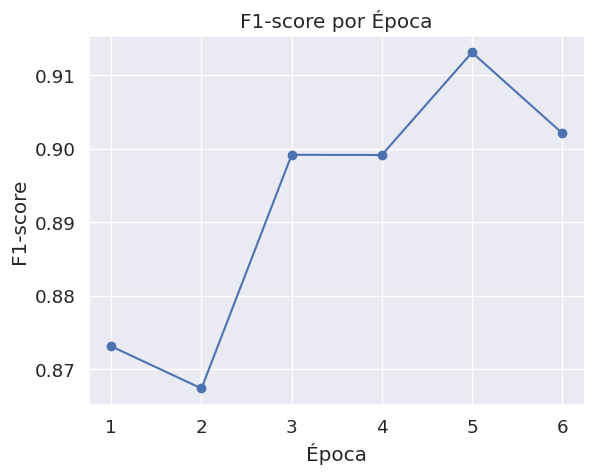

In [ ]:
checkpoint_callback.best_model_path
import matplotlib.pyplot as plt

# Después de completar el entrenamiento
epochs = list(range(1, len(pl_model.val_f1_scores) + 1))
plt.plot(epochs, pl_model.val_f1_scores, marker='o')
plt.xlabel('Época')
plt.ylabel('F1-score')
plt.title('F1-score por Época')
plt.grid(True)
plt.show()

In [333]:
best_model = checkpoint_callback.best_model_path
# best_model = "/content/drive/MyDrive/Wav2Vec2_ORVP/wav2vec2_huggingface_fairseq_orvp_test1-epoch=4-step=23459.ckpt"
print(best_model)
test_model = Wav2Vec2_sound_detection.load_from_checkpoint(best_model, hparams=hparams).cuda().eval()

/home/cslab03/Desktop/test2/wav2vec2-sound_sismic_train-v10.ckpt


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [334]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                            collate_fn = data_collator,
                            shuffle=False, num_workers=0)

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

tensor([[-0.1322, -0.1164,  0.3126,  ..., -0.4486, -0.1287,  0.2661],
        [-0.1473, -0.1300,  0.3095,  ..., -0.4234, -0.1243,  0.2544],
        [-0.0042,  0.0211,  0.2714,  ..., -0.3460,  0.0213,  0.2472],
        ...,
        [ 0.0191, -0.0412,  0.1098,  ...,  0.0136, -0.0116,  0.2410],
        [ 0.0163, -0.0300,  0.1291,  ..., -0.0420, -0.0067,  0.2423],
        [-0.1263, -0.1161,  0.3198,  ..., -0.4490, -0.1296,  0.2561]],
       device='cuda:0')
tensor([[ 0.0017, -0.0091,  0.1711,  ..., -0.1480,  0.0039,  0.2615],
        [-0.0050,  0.0202,  0.2895,  ..., -0.3784,  0.0156,  0.2417],
        [-0.1439, -0.1280,  0.3190,  ..., -0.4488, -0.1230,  0.2648],
        ...,
        [ 0.0010,  0.0196,  0.2838,  ..., -0.3714,  0.0135,  0.2417],
        [ 0.0104, -0.0127,  0.1594,  ..., -0.1178, -0.0014,  0.2605],
        [ 0.0101, -0.0019,  0.1934,  ..., -0.1911,  0.0024,  0.2534]],
       device='cuda:0')
tensor([[-0.0025,  0.0243,  0.2826,  ..., -0.3729,  0.0168,  0.2393],
        [-0.12

[{'test_acc': 0.9413071274757385,
  'test_f1': 0.9414291977882385,
  'test_loss': 0.17307044565677643}]

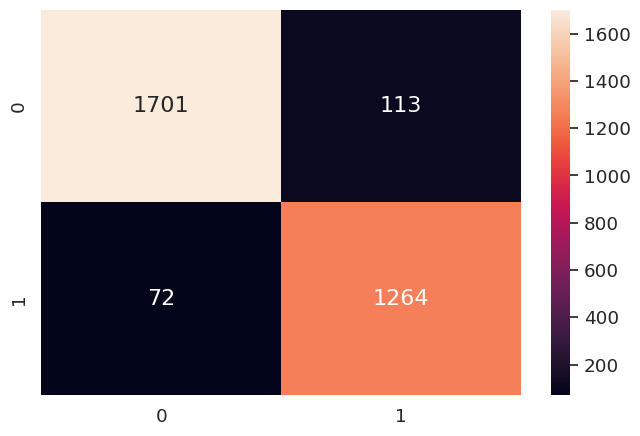

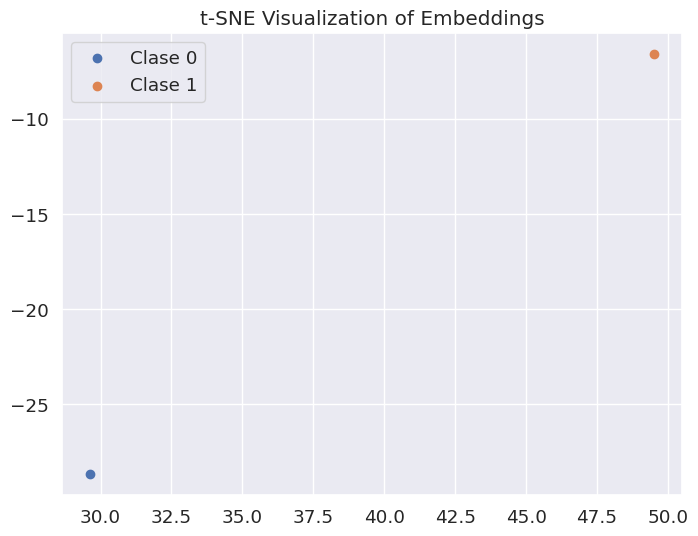

In [335]:
trainer.test(test_model, test_dataloader)

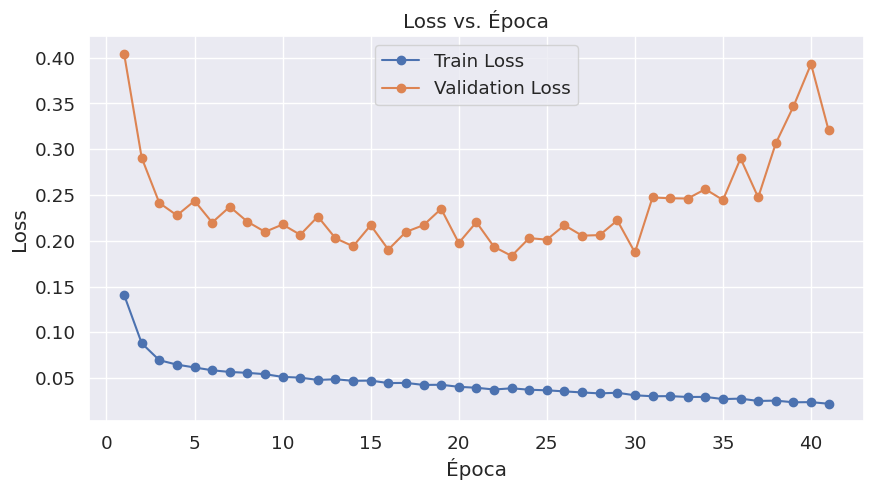

In [336]:
import matplotlib.pyplot as plt

# Después de completar el entrenamiento
epochs = list(range(1, len(pl_model.train_losses) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, pl_model.train_losses, label='Train Loss', marker='o')
plt.plot(epochs, pl_model.val_losses, label='Validation Loss', marker='o')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Loss vs. Época')
plt.legend()
plt.grid(True)
plt.show()
